# UTCI above 32°C threshold

This notebook aims to plot gridded 1x1 global maps of the UTCI above 32°C historical (1985-2015) and projected (2015-2100) UTCI with functionality to extract by AR5 region using the library regionmask

In [51]:
from itertools import chain
from glob import glob
import numpy as np
import xarray as xr

In [52]:
# Plotting libraries:
import matplotlib
import matplotlib.pyplot as plt; plt.close('all')
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib import colors as mcol
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.ticker as mticker

# Mapping libraries:
import cartopy
import cartopy.crs as ccrs
from cartopy.io import shapereader
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# GEO libraries:
import geopandas as gp
import regionmask

In [53]:
%matplotlib inline

## Datasets

3 sources x 3 SSPs:

```
/gws/pw/j05/cop26_hackathons/bristol/project10/

~/utci_projections_1deg/BCC-CSM2-MR/historical/r1i1p1f1 # (1985-2015)
~/utci_projections_1deg/BCC-CSM2-MR/ssp126/r1i1p1f1 # (2015-2101)
~/utci_projections_1deg/BCC-CSM2-MR/ssp245/r1i1p1f1 # (2015-2101)
~/utci_projections_1deg/BCC-CSM2-MR/ssp585/r1i1p1f1 # (2015-2101)
~/utci_projections_1deg/CMCC-ESM2/historical/r1i1p1f1/ # (1985-2015)
~/utci_projections_1deg/CMCC-ESM2/ssp126/r1i1p1f1 # (2015-2101)
~/utci_projections_1deg/CMCC-ESM2/ssp245/r1i1p1f1 # (2015-2101)
~/utci_projections_1deg/CMCC-ESM2/ssp585/r1i1p1f1 # (2015-2101)
~/utci_projections_1deg/HadGEM3-GC31-LL/historical/r1i1p1f3/ # (1985-2015)
~/utci_projections_1deg/HadGEM3-GC31-LL/ssp126/r1i1p1f3 # (2015-2101)
~/utci_projections_1deg/HadGEM3-GC31-LL/ssp245/r1i1p1f3 # (2015-2101)
~/utci_projections_1deg/HadGEM3-GC31-LL/ssp585/r1i1p1f3 # (2015-2101)
```

## Settings

In [54]:
cmap = 'gist_heat_r'
fontsize = 14
cbstr = r'UTCI [$^{\circ}$C]'
projection = 'robinson'
if projection == 'platecarree': p = ccrs.PlateCarree(central_longitude=0); threshold = 0
if projection == 'mollweide': p = ccrs.Mollweide(central_longitude=0); threshold = 1e6
if projection == 'robinson': p = ccrs.Robinson(central_longitude=0); threshold = 0
if projection == 'equalearth': p = ccrs.EqualEarth(central_longitude=0); threshold = 0
if projection == 'geostationary': p = ccrs.Geostationary(central_longitude=0); threshold = 0
if projection == 'goodehomolosine': p = ccrs.InterruptedGoodeHomolosine(central_longitude=0); threshold = 0
if projection == 'europp': p = ccrs.EuroPP(); threshold = 0
if projection == 'northpolarstereo': p = ccrs.NorthPolarStereo(); threshold = 0
if projection == 'southpolarstereo': p = ccrs.SouthPolarStereo(); threshold = 0
if projection == 'lambertconformal': p = ccrs.LambertConformal(central_longitude=0); threshold = 0

## Land-Sea Mask

I regridded a land-sea mask I have for 20CRv3 to 1x1 and then reset the longitude dimension to match the CMIP6 UTCI dataset format. I use CDO to reset the longitude with:
```
cdo sellonlatbox,-180,180,-90,90 landseamask_1x1.nc landseamask.nc
```
Q. Does anyone need UTCI over sea?

In [55]:
#project_directory = '/gws/pw/j05/cop26_hackathons/bristol/project10/'

In [56]:
project_directory = './'

In [57]:
landseamask = xr.load_dataset(project_directory + 'landseamask.nc')

## Lazy load data

In [58]:
#data_directory = project_directory + 'utci_projections_1deg/BCC-CSM2-MR/historical/r1i1p1f1/'
data_directory = project_directory
filelist = data_directory + 'utci_3hr*.nc'

In [59]:
paths_to_load = [ glob(filelist) for variable in ['utci'] ]
dataset = xr.open_mfdataset(paths=chain(*paths_to_load))

## Convert UTCI to degrees Centigrade, set the 32 degree threshold, apply land mask and average over time dimension

In [60]:
utci = dataset.utci[:,:,:]-273.15
threshold = 32.0
utci_over_threshold = xr.where(utci>threshold, utci, np.nan)
utci_over_threshold_mean = utci_over_threshold.mean('time').where(landseamask.LSMASK)

## Xarray plotting function with 5x5 grid overlay

In [61]:
def make_plot(axi,v,vmin,vmax,cbstr,titlestr,cmap,fontsize):

    g = v.plot(ax=axi, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, cmap=cmap, cbar_kwargs={'orientation':'vertical','extend':'both','shrink':0.7, 'pad':0.1})         
    cb = g.colorbar; cb.ax.tick_params(labelsize=fontsize); cb.set_label(label=cbstr, size=fontsize); cb.remove()
    axi.set_global()        
    axi.coastlines(color='grey')
    axi.set_title(titlestr, fontsize=fontsize)    
    gl = axi.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='black', alpha=0.2, linestyle='-')
    gl.top_labels = False; gl.bottom_labels = False; gl.left_ylabels = False; gl.right_ylabels = False
    gl.xlines = True; gl.ylines = True
    gl.xlocator = mticker.FixedLocator(np.linspace(-180,180,73)) # every 5 degrees
    gl.ylocator = mticker.FixedLocator(np.linspace(-90,90,37))   # every 5 degrees
    gl.xformatter = LONGITUDE_FORMATTER; gl.yformatter = LATITUDE_FORMATTER

    return g

## Plot the map

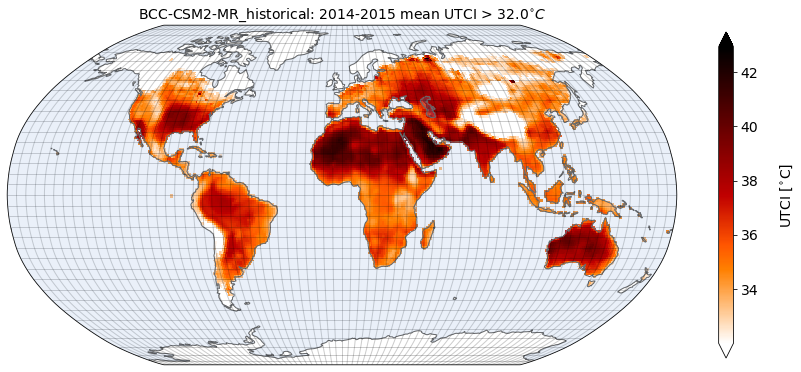

In [76]:
plotfile = 'utci_over_' + str(threshold) + '.png'
titlestr = 'BCC-CSM2-MR_historical: 2014-2015 mean UTCI > ' + str(threshold) + r'$^{\circ}C$'    

fig, axs = plt.subplots(1,1, figsize=(15,10), subplot_kw=dict(projection=p))
vmin = np.nanmin(utci_over_threshold_mean); vmax = np.nanmax(utci_over_threshold_mean)
g = make_plot(axs, utci_over_threshold_mean, vmin, vmax, cbstr, titlestr, cmap, fontsize)
axs.add_feature(cartopy.feature.OCEAN, zorder=100, alpha=0.2, edgecolor='k')
#cb = fig.colorbar(g, ax=axs.ravel().tolist(), shrink=0.6, extend='both')
cb = fig.colorbar(g, ax=axs, shrink=0.6, extend='both')
cb.set_label(cbstr, rotation=90, labelpad=20, fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
#cb.set_ticks(np.linspace(vmin,vmax,17))
plt.savefig(plotfile, dpi=300)
plt.show()

## Define AR5 regions

Regionmask works great for Giorgi and SREX regions (AR5):

In [77]:
#regions_ar6 = regionmask.defined_regions.ar6.all
regions_giorgi = regionmask.defined_regions.giorgi
regions_srex = regionmask.defined_regions.srex
ar5regions = regions_giorgi

In [78]:
ar5regions

<regionmask.Regions>
Name:     Giorgi
Source:   Giorgi and Franciso, 2000 (http://link.springer.com/article/10.1007...

Regions:
  1  AUS               Australia
  2  AMZ            Amazon Basin
  3  SSA  Southern South America
  4  CAM         Central America
  5  WNA   Western North America
..   ...                     ...
 17  EAS               East Asia
 18  SAS              South Asia
 19  CAS            Central Asia
 20  TIB                   Tibet
 21  NAS              North Asia

[21 regions]

<GeoAxesSubplot:>

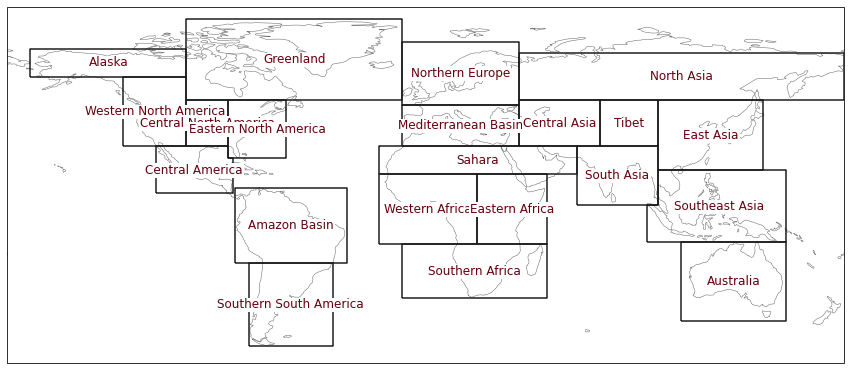

In [79]:
text_kws = dict(color="#67000d", fontsize=12, bbox=dict(pad=0.2, color="w"))

fig, axs = plt.subplots(1,1, figsize=(15,10), subplot_kw=dict(projection=p))
#regions_giorgi.plot(label='abbrev', text_kws=text_kws)
#regions_giorgi.plot(label='name', text_kws=text_kws)
ar5regions.plot(label='name', text_kws=text_kws)

## Mask to a region

The aim here is to be able to plot the spatial variation of the UTCI in a region and to enable extraction and calculation of a regional mean UTCI timeseries. Let's have a look at the Amazon as an example.

In [84]:
mask = ar5regions.mask_3D(dataset.lon, dataset.lat)

In [85]:
r = mask.isel(region=(mask.names == "Amazon Basin"))
utci_region = utci_over_threshold_mean.where(r)

/local/cqz20mbu/miniconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


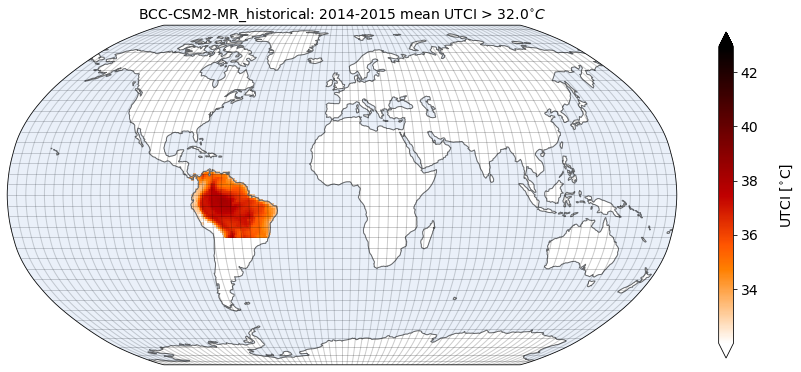

In [86]:
plotfile = 'utci_over_' + str(threshold) + '_' + 'region' + '.png'
titlestr = 'BCC-CSM2-MR_historical: 2014-2015 mean UTCI > ' + str(threshold) + r'$^{\circ}C$'    

fig, axs = plt.subplots(1,1, figsize=(15,10), subplot_kw=dict(projection=p))
#vmin = np.nanmin(utci_region); vmax = np.nanmax(utci_region)
g = make_plot(axs, utci_region, vmin, vmax, cbstr, titlestr, cmap, fontsize)
axs.add_feature(cartopy.feature.OCEAN, zorder=100, alpha=0.2, edgecolor='k')
#cb = fig.colorbar(g, ax=axs.ravel().tolist(), shrink=0.6, extend='both')
cb = fig.colorbar(g, ax=axs, shrink=0.6, extend='both')
cb.set_label(cbstr, rotation=90, labelpad=20, fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
#cb.set_ticks(np.linspace(vmin,vmax,17))
plt.savefig(plotfile, dpi=300)
plt.show()